#### Procesamiento Digital de Señales

# Tarea Semanal 4

#### Por Nahuel Braian Contreras

## Consigna
 
#### Simulación de un ADC (cuantización) parte 2/2 <br>
En esta tarea semanal retomamos la consigna de la tarea anterior, donde simulamos el bloque de cuantización de un ADC de B bits en un rango de ±$V_{F}$ Volts. Ahora vamos a completar la simulación del ADC incluyendo la capacidad de muestrear a fs Hertz.
 
Para ello se simulará el comportamiento del dispositivo al digitalizar una senoidal contaminada con un nivel predeterminado de ruido. Comenzaremos describiendo los parámetros a ajustar de la senoidal:
 
* frecuencia $f_{0}$ arbitraria, por ejemplo $f_{0}=f_{S/N}=Δf$, 
* energía normalizada, es decir energía (o varianza) unitaria

Con respecto a los parámetros de la secuencia de ruido, diremos que:
 
* será de carácter aditivo, es decir la señal que entra al ADC será $s_{R}=s+n$. Siendo n la secuencia que simula la interferencia, y s la senoidal descrita anteriormente.
* La potencia del ruido será $Pn=kn.Pq W$ siendo el factor k una escala para la potencia del ruido de cuantización $Pq=\frac{q^{2}}{12}$
* finalmente, n será incorrelado y Gaussiano.
 
El ADC que deseamos simular trabajará a una frecuencia de muestreo $f_{S}$=1000 Hz y tendrá un rango analógico de ±$V_{F}=2$ Volts.

## Analisis de las señales

### a) B = 4 bits, kn=1

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy.fft import fft, fftshift

def my_senoidal (N, freq_M, amplitud = 1, valor_medio = 0, freq = 1, fase = 0):
    
    ts = 1/freq_M
    
    tt = np.linspace(0, (N-1)*ts, N)
    
    xx = amplitud * np.sin(2*np.pi*(freq)*tt + fase) + valor_medio
    
    return(tt,xx)

def my_ADC(Sr, B, Vref):
    
    q = Vref/(2**(B-1)) # LSB
    Sq = q * np.round(Sr/q)
    error = Sq - Sr
    return Sq, error

def ADC_analisis(kn,fs,N,B,Vref,Amplitud,ff = 1):

    ts = 1/fs
    
    q = Vref/(2**(B-1))
    
    over_sampling = 1
    N_os = N*over_sampling
    fs_os = fs*over_sampling
    

    [tt_os, analog_sig] = my_senoidal(N_os,fs_os,amplitud = Amplitud,freq = ff) # creo mi señal senoidal con OS
    tt = np.linspace(0, (N-1)*ts, N) #vector temporal sin OS
    
    q = Vref/(2**(B-1)) # LSB
    pot_ruido = ((q**2)/12 )* kn # Watts (potencia de la señal 1 W)
    desvio = np.sqrt(pot_ruido)
    
    #Metodo de definir manualmente un piso de ruido analogico
    #SNR = 40
    #Sigma_2 = Amplitud**2/(2*10**(SNR/20))
    #noise_a = np.sqrt(Sigma_2) * np.random.randn(len(analog_sig))
    # SNR_f = 10*np.log10(Amplitud**2/(2*Sigma_2)) ## verifico que obtuve mi SNR
    
    # Ruido incorrelado y gaussiano
    n = np.random.normal(0, desvio, size=N_os)
    #signal_ruido = analog_sig + n
    signal_ruido = analog_sig + n
    
    sr = signal_ruido[::over_sampling] #le saco el OS a mi señal ruidosa
    
    #ADC
    srq, nq= my_ADC(sr,B,Vref)
    
    # Densidad espectral de potencia
    ff = np.arange(0, fs, fs/N)
    ff_os = np.arange(0, fs_os, fs_os/N_os)
    ft_Srq = fft(srq,N)/srq.shape[0]
    ft_As = fft(analog_sig,N_os)/analog_sig.shape[0]
    ft_SR = fft(sr,N)/sr.shape[0]
    ft_Nn = fft(n,N_os)/n.shape[0]  #piso de ruido analogico -> ruido gausseano
    ft_Nq = fft(nq,N)/nq.shape[0]   #piso de ruido digital -> error cuantizacion
    
    bfrec = ff <= fs/2
    nNn_mean = np.mean(np.abs(ft_Nn)**2)
    Nnq_mean = np.mean(np.abs(ft_Nq)**2)
    
    plt.close('all')
     
    plt.figure(1)
    plt.gcf().set_size_inches(16, 12)
    plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
    plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')
    plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
    plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Amplitud, q) )
    plt.xlabel('tiempo [segundos]')
    plt.ylabel('Amplitud [V]')
    axes_hdl = plt.gca()
    axes_hdl.legend()
    plt.show()
     
    plt.figure(2) 
    plt.gcf().set_size_inches(16, 12)
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)' )
    plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
    plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
    plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
    plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
    plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Amplitud, q) )
    plt.ylabel('Densidad de Potencia [dB]')
    plt.xlabel('Frecuencia [Hz]')
    axes_hdl = plt.gca()
    axes_hdl.legend()
    # suponiendo valores negativos de potencia ruido en dB
    plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))
     
     
    plt.figure(3)
    plt.gcf().set_size_inches(16, 12)
    bins = 10
    plt.hist(nq, bins=bins)
    plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
    plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Amplitud, q))

    return

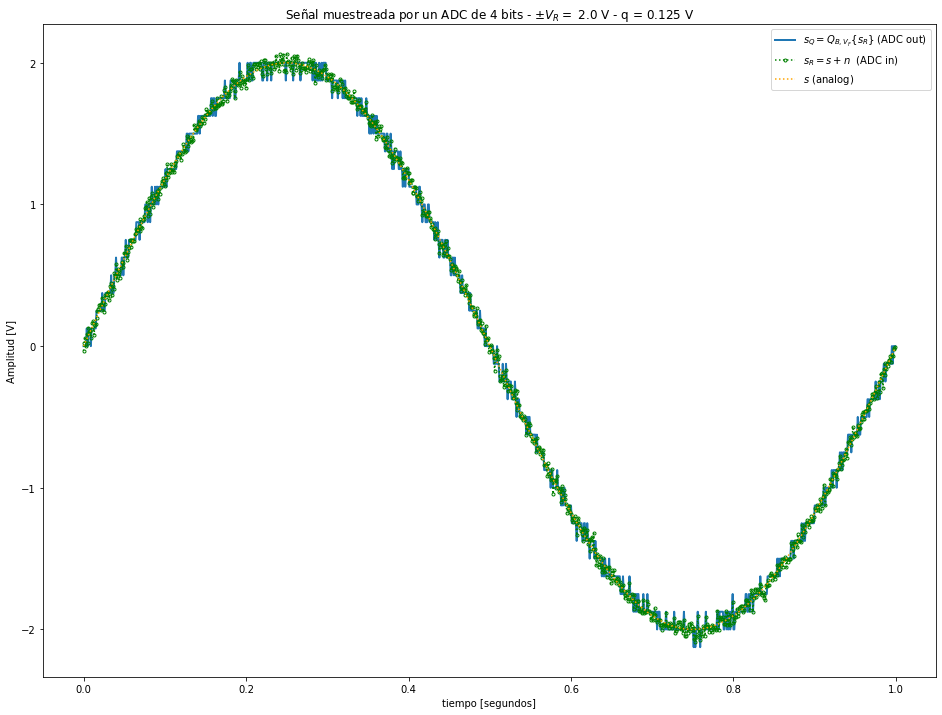

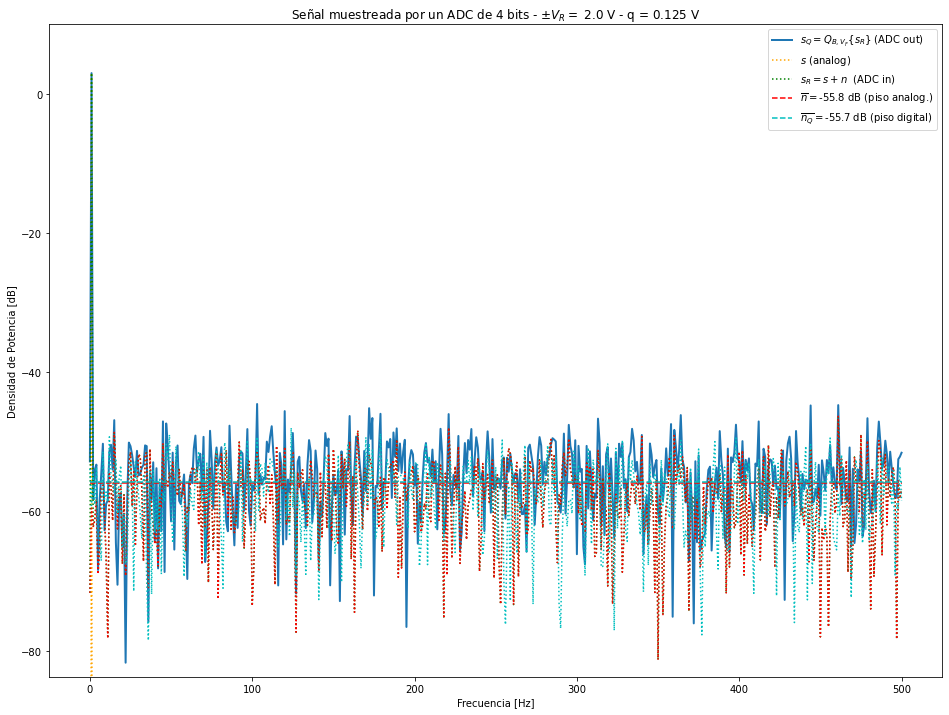

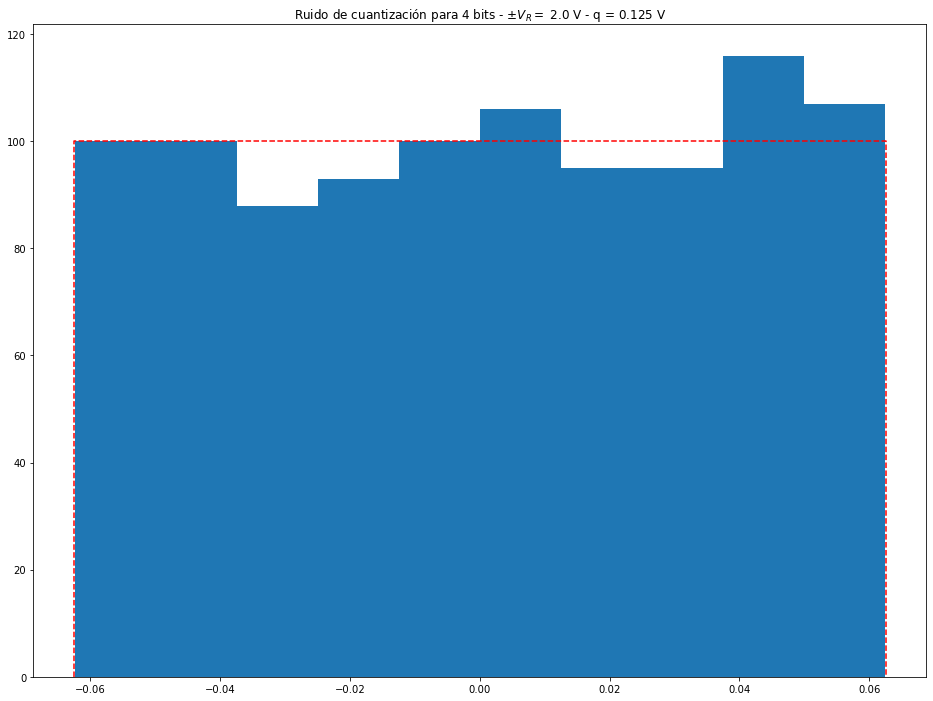

In [22]:
kn = 1
fs = 1000
N = 1000
B = 4
Vref = 1
A = 2

ADC_analisis(kn,fs,N,B,Vref,A)

Podemos notar que debido a que el valor de Kn =  1, el nivel del piso del ruido analógico es similar al del digital.

### b)

 Analizaremos diferentes configuraciones de parametros. Tendremos que B podra valor entre ̣{4, 8 y 16} bits,y para cada valor de B, analizaremos como se ve la señal para los siguientes valore de kn={1/10,1,10}
 

#### B = 4 bits, kn=0.1

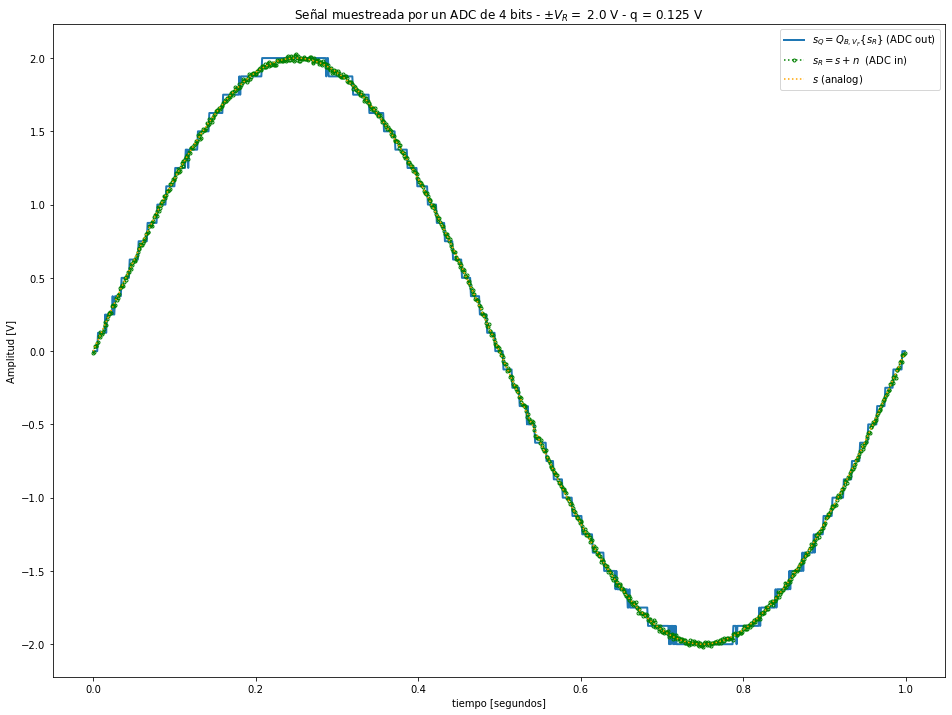

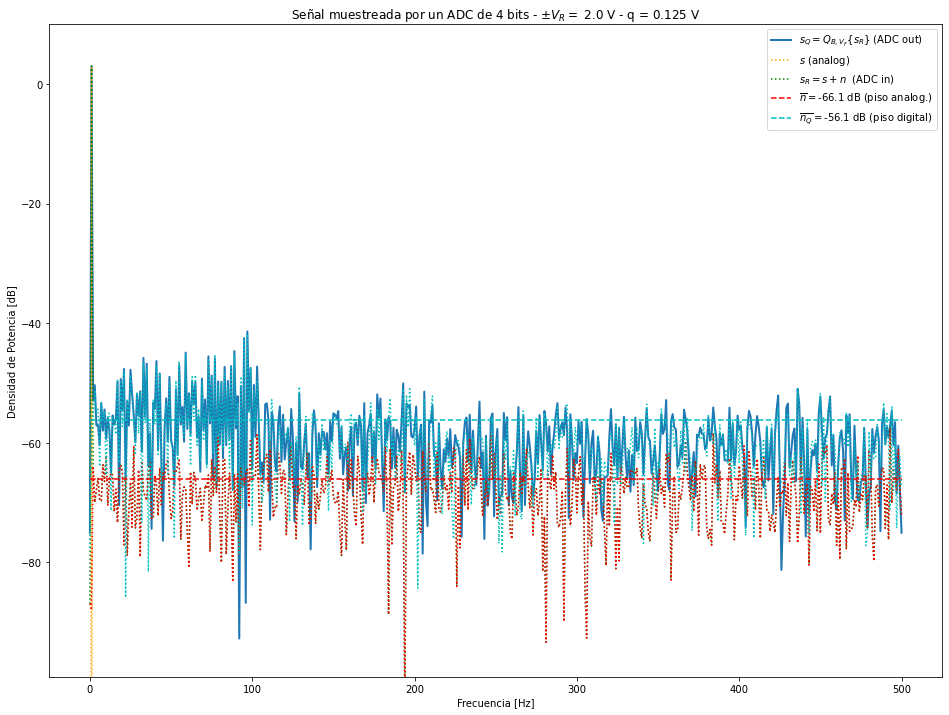

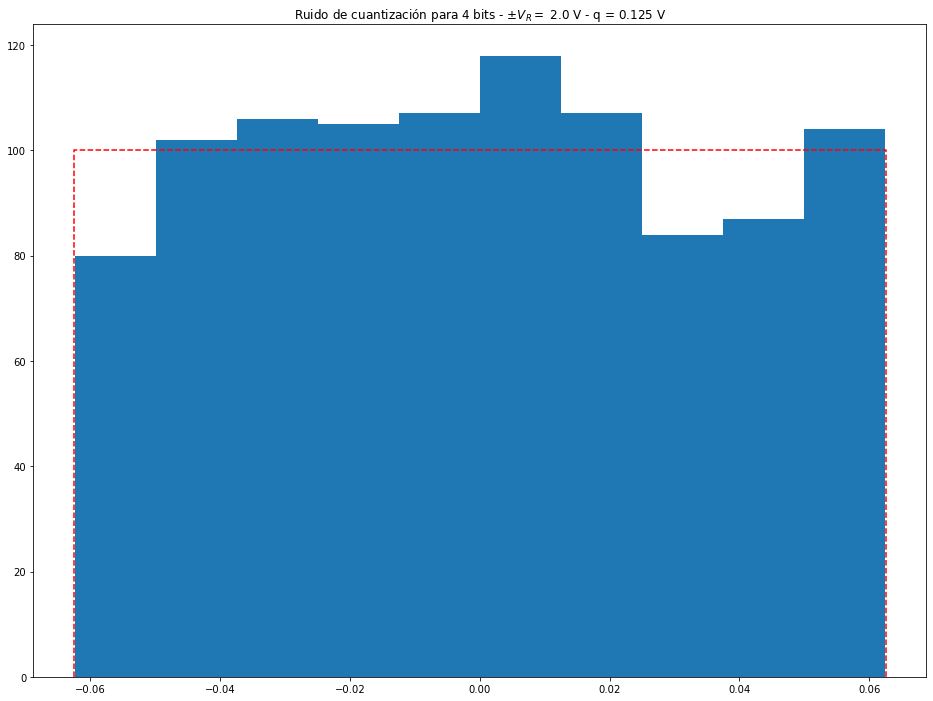

In [23]:
B = 4
kn = 1/10
ADC_analisis(kn,fs,N,B,Vref,A)

Debido a que Kn < 1, la potencia de la señal de ruido disminuye haciendo que el nivel del piso analógico sea menor que el nivel del digital.

#### B = 4 bits, kn=10

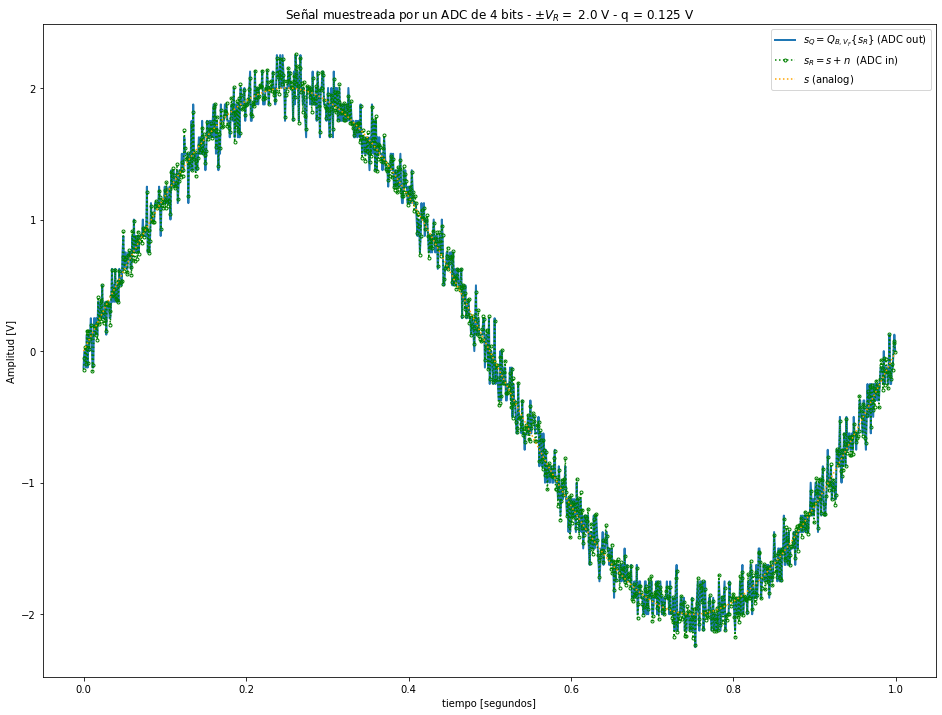

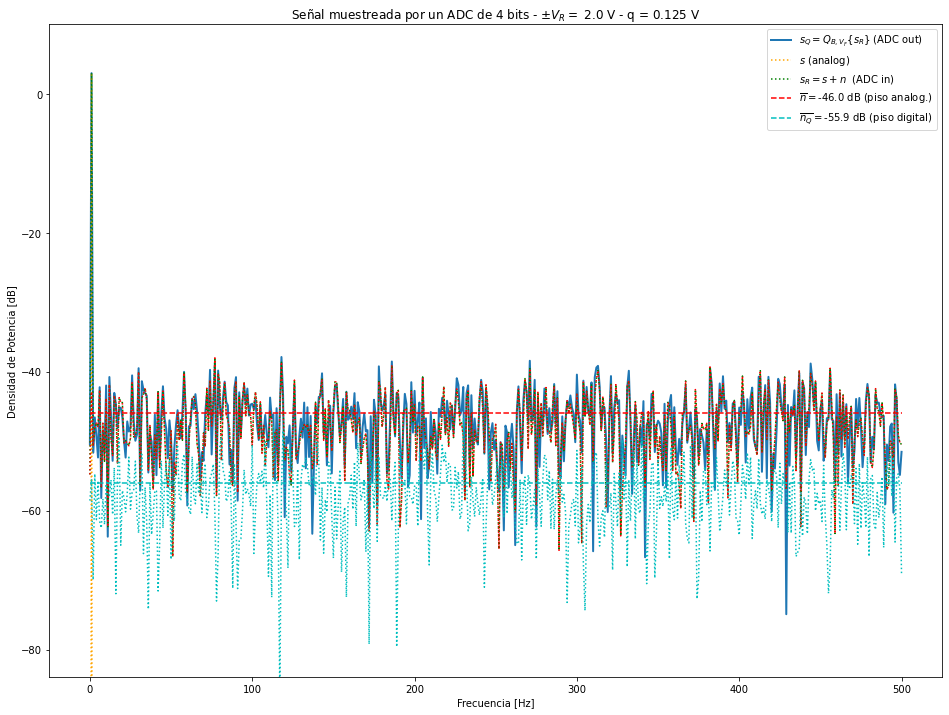

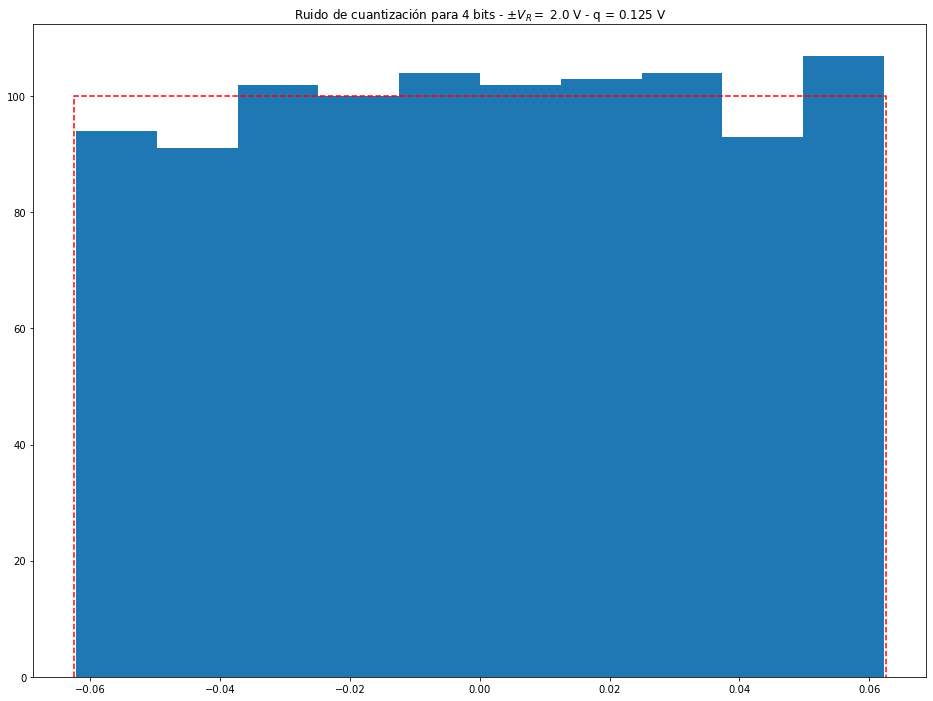

In [24]:
B = 4
kn = 10
ADC_analisis(kn,fs,N,B,Vref,A)

Al reves que en el caso anterior la potencia del ruido aumenta, por lo que el nivel de del piso de ruido analógico

#### B = 8 bits, kn=0.1

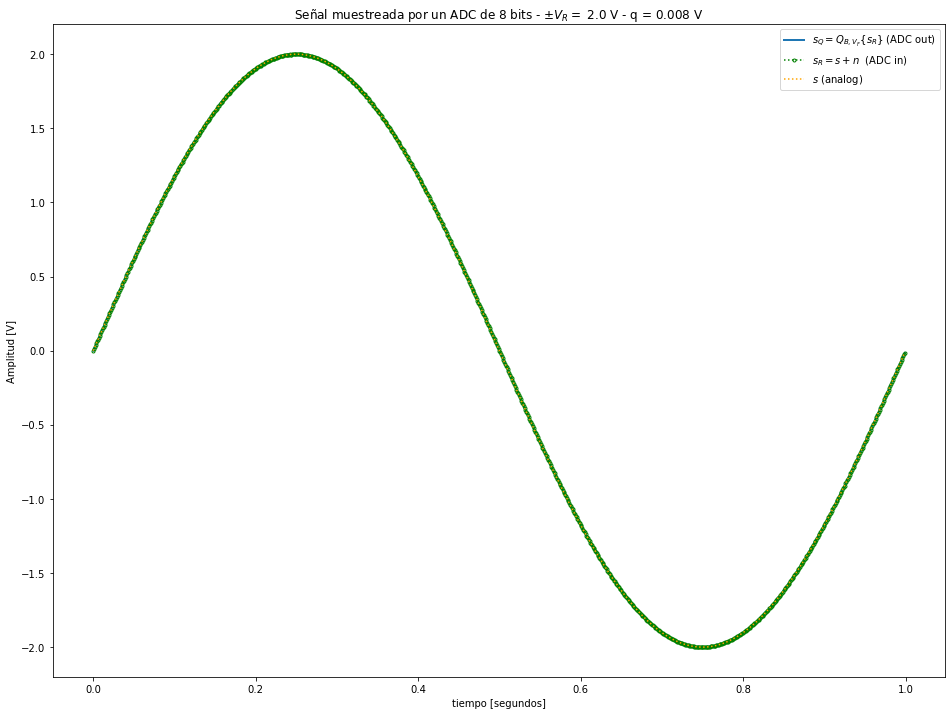

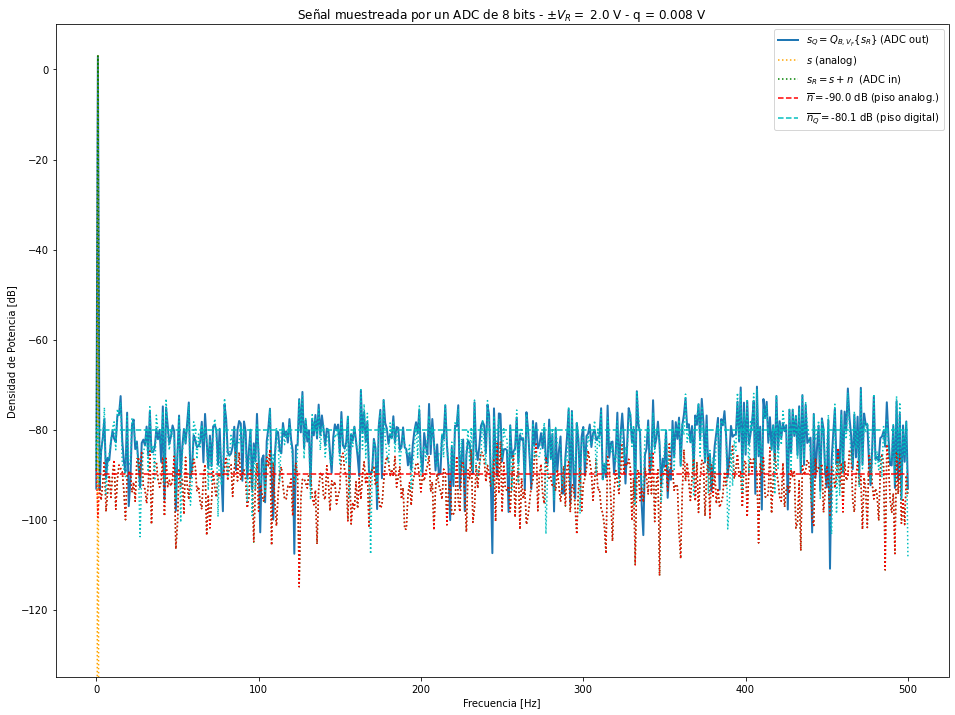

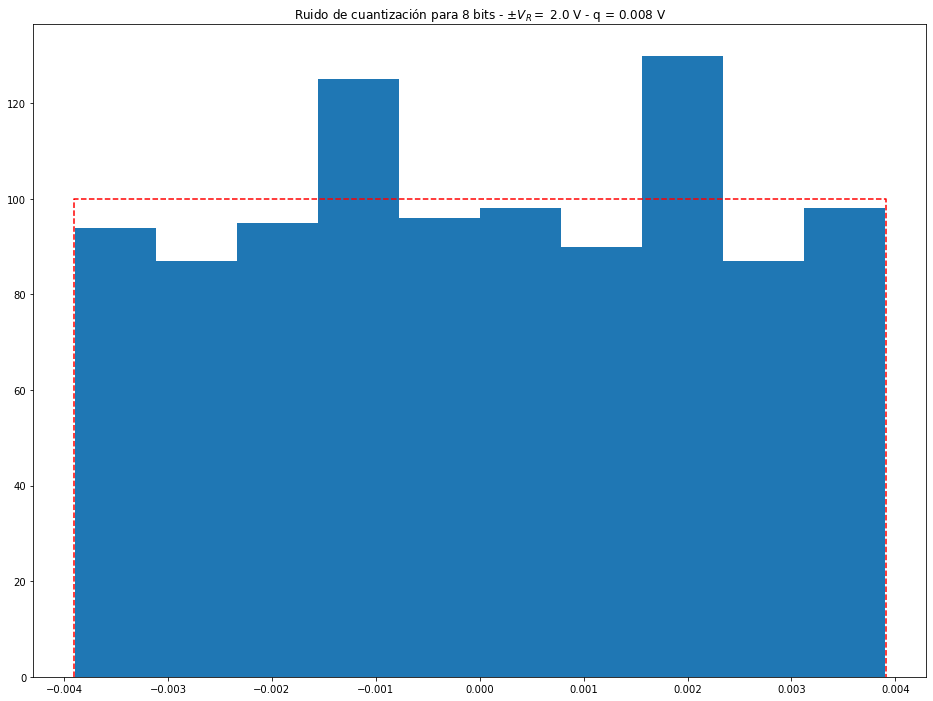

In [25]:
B = 8
kn = 1/10
ADC_analisis(kn,fs,N,B,Vref,A)

#### B = 8 bits, kn=1

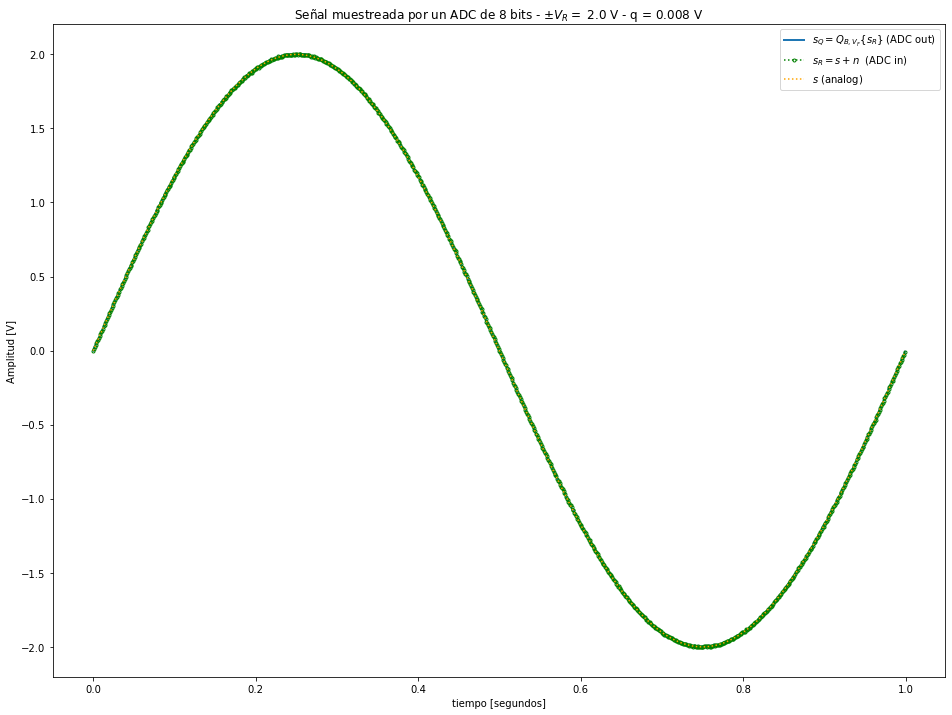

C:\Users\Nahuel\AppData\Local\Temp\ipykernel_80812\2128806480.py:86: RuntimeWarning: divide by zero encountered in log10
  plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)' )


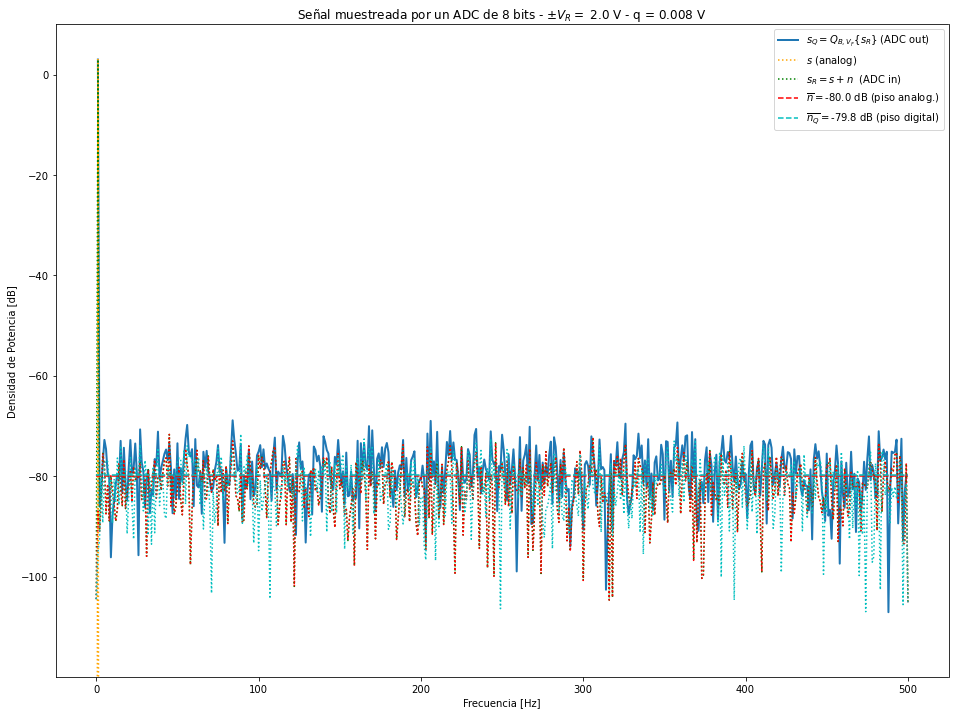

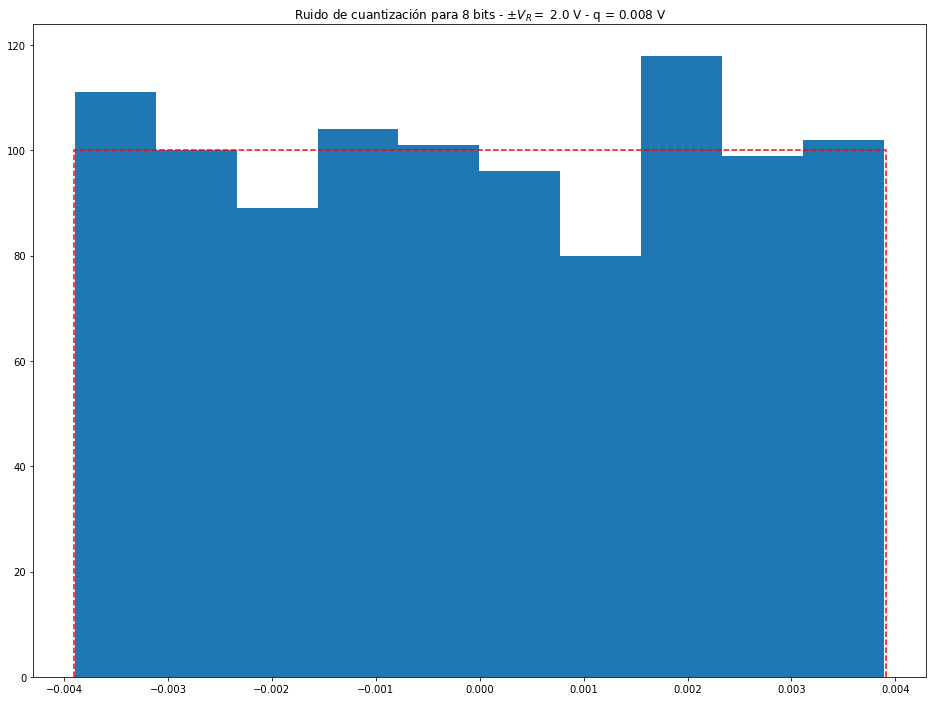

In [26]:
B = 8
kn = 1
ADC_analisis(kn,fs,N,B,Vref,A)

#### B = 8 bits, kn=10

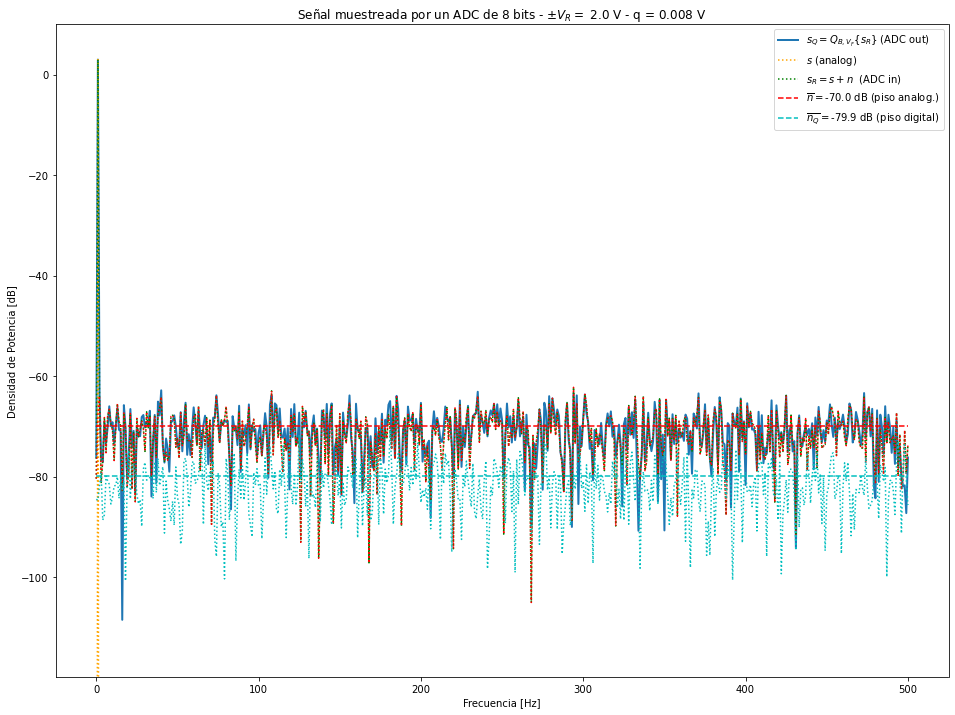

In [27]:
B = 8
kn = 10
ADC_analisis(kn,fs,N,B,Vref,A)

Para 8 bits, podemos notar que el los niveles de piso analógico y digital disminuyeron. Cada uno varia su nivel de piso de acuerdo al parámetro kn

#### B = 16 bits, kn=0.1

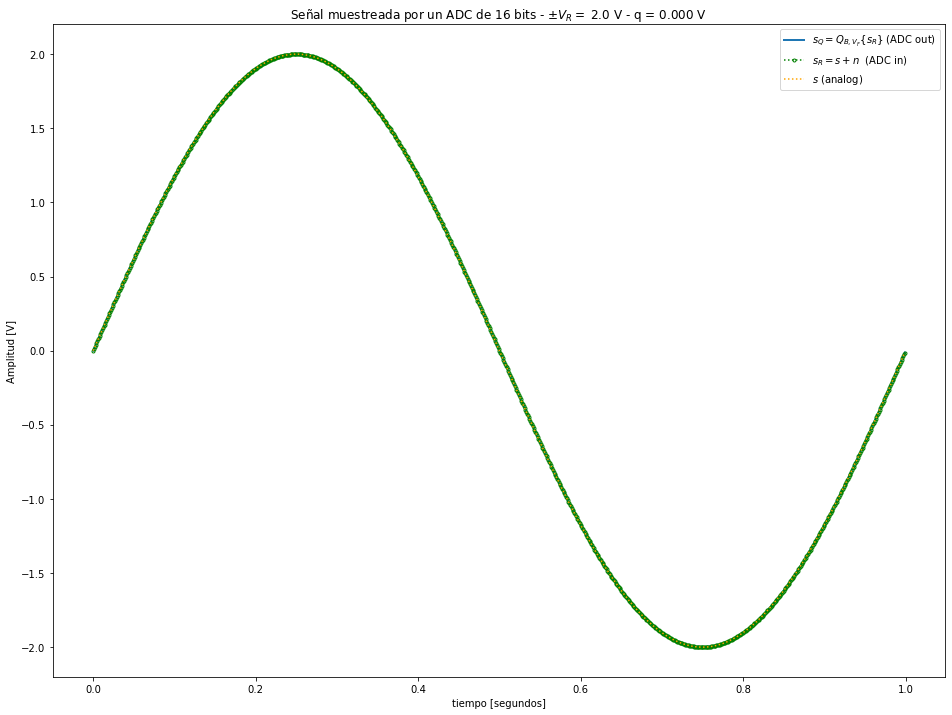

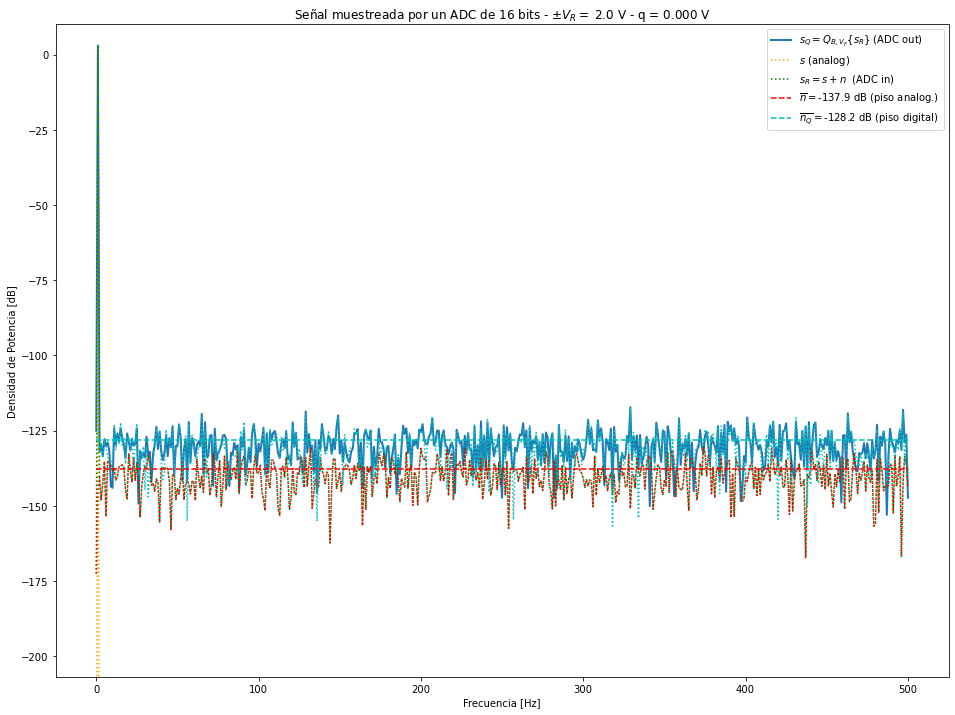

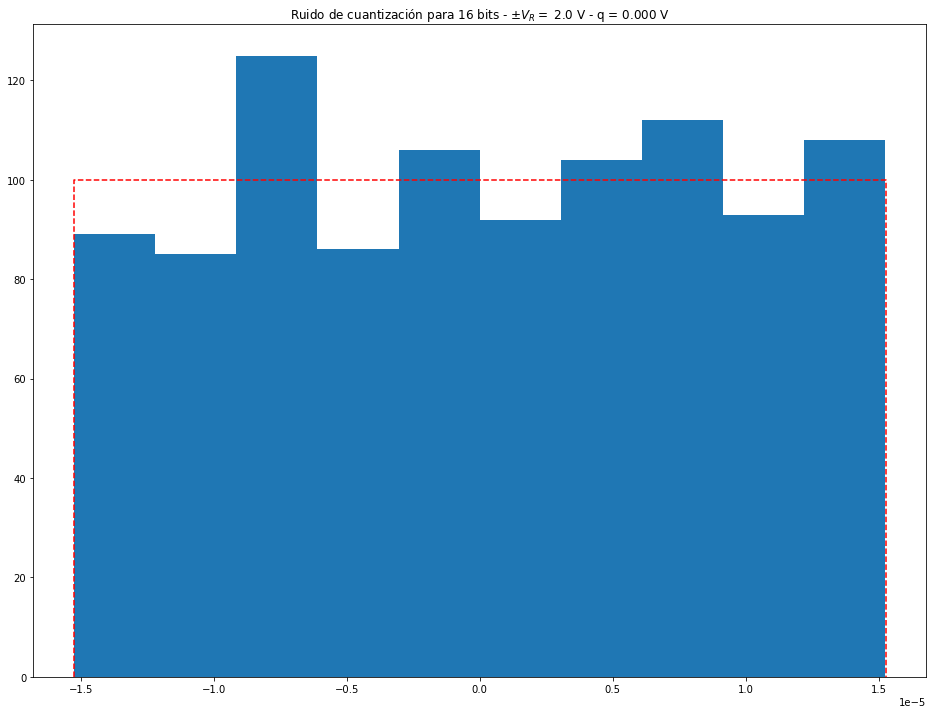

In [28]:
B = 16
kn = 1/10
ADC_analisis(kn,fs,N,B,Vref,A)

#### B = 16 bits, kn=1

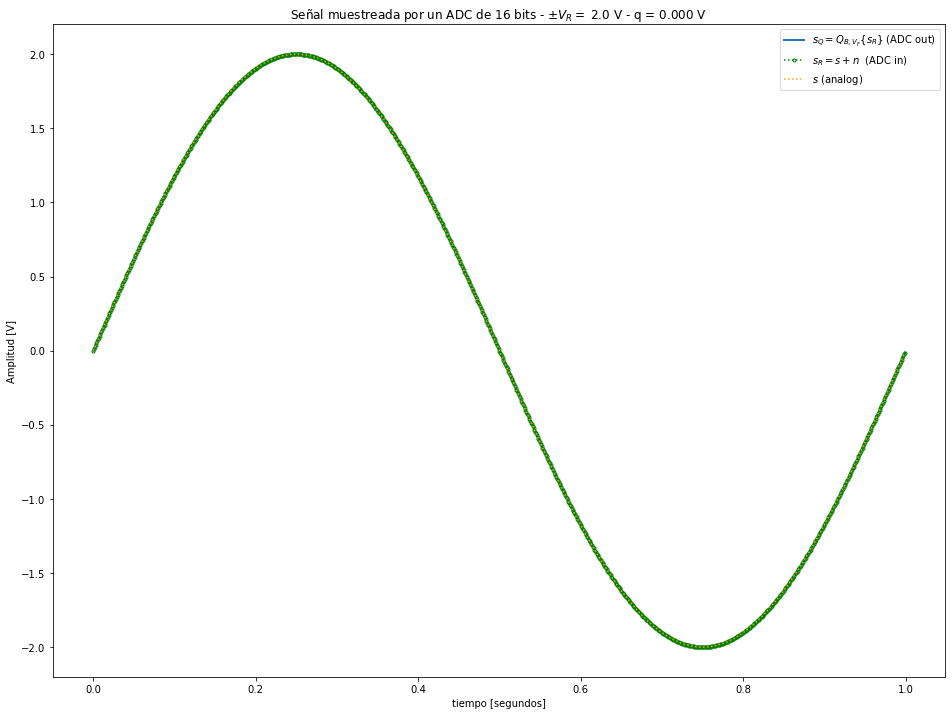

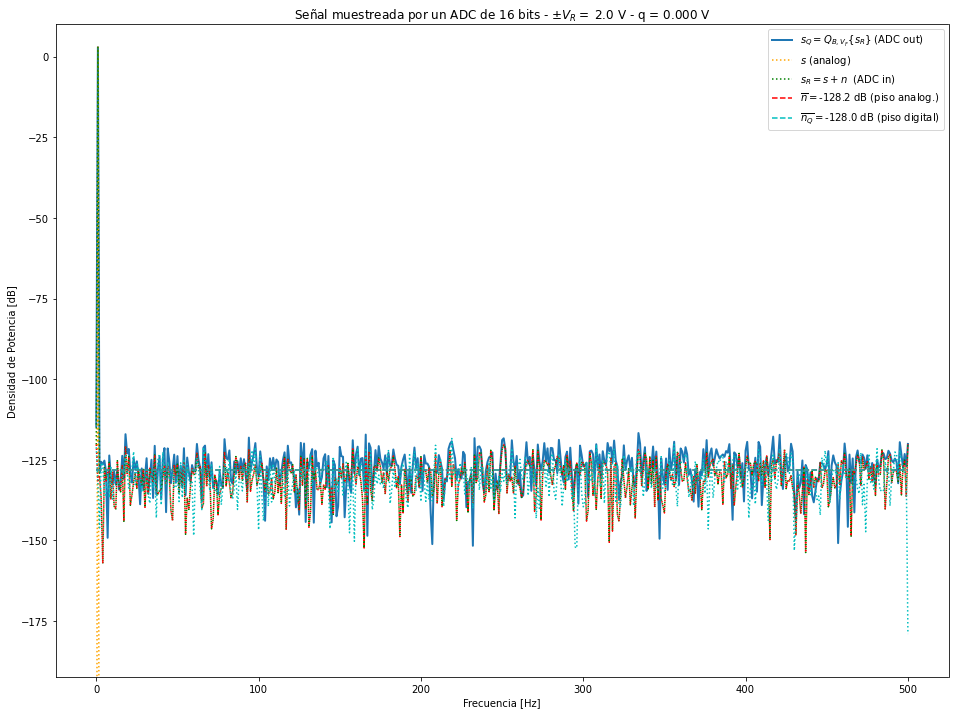

In [29]:
B = 16
kn = 1
ADC_analisis(kn,fs,N,B,Vref,A)

#### B = 16 bits, kn=10

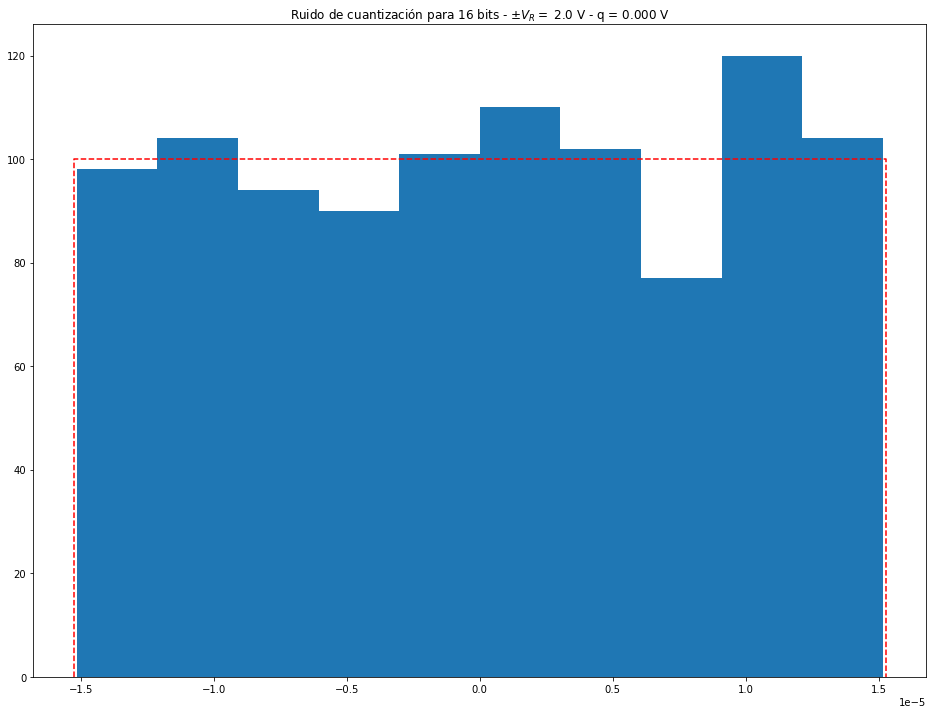

In [30]:
B = 16
kn = 10
ADC_analisis(kn,fs,N,B,Vref,A)

Para 16 bits tenemos los nivels de piso de ruido más bajos en el analisis. Tambien su nivel varía de acuerdo al valor de kn

## Efecto Aliasing

Nyquist nos dice que para evitar el efecto de Alias, se tiene que cumplir que

$$f_s >= 2.f_0$$

Para simular este efecto, generaremos una señal y la muestrearemos a una frecuencia incorrecta.

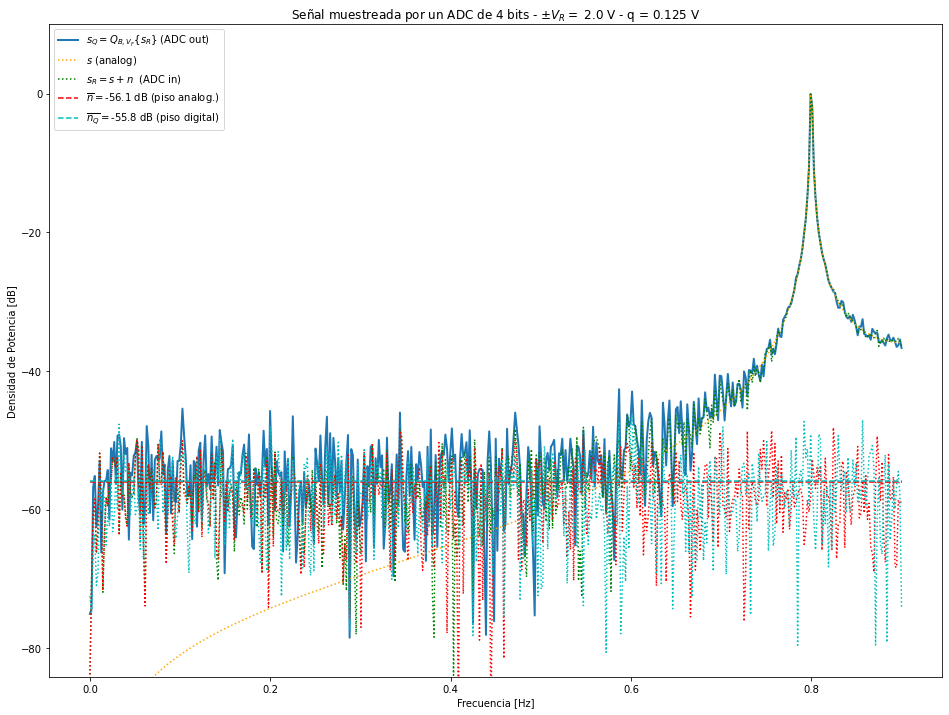

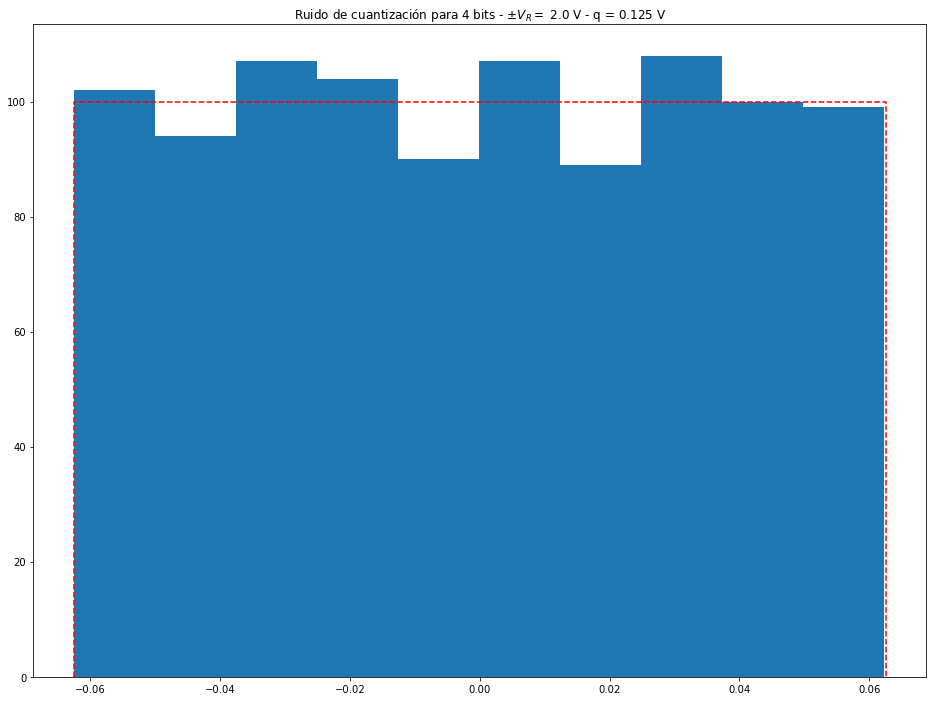

In [31]:
factor = 0.9 # factor para hacer que fs < 2.ff
frec = 1
fs = 2*frec*factor

B = 4
kn = 1

ADC_analisis(kn,fs,N,B,Vref,A,ff = frec)

En el gráfico de la densidad espectral de potencia podemos observa que el efecto del aliasing genera una superoposición de las frecuencias, lo que conlleva en un aumento de su potencia.